# Did instructors take longer to grade assignments after COVID?

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statistics
import matplotlib.dates as mdates
import datetime
import matplotlib.ticker as ticker
import pickle
import sys
sys.path.insert(0, '/home/jenny/remote_learning_code_Spring_2017-2020')
from utils import parse_args

sys.argv = ['-f']
args = parse_args()

term_20 = args.semester_2020_Spring
start_date_20 = args.start_date_2020_Spring
remote_date_20 = args.remote_date_2020_Spring
end_date_20 = args.end_date_2020_Spring

term_19 = args.semester_2019_Spring
start_date_19 = args.start_date_2019_Spring
end_date_19 = args.end_date_2019_Spring

term_18 = args.semester_2018_Spring
start_date_18 = args.start_date_2018_Spring
end_date_18 = args.end_date_2018_Spring

term_17 = args.semester_2017_Spring
start_date_17 = args.start_date_2017_Spring
end_date_17 = args.end_date_2017_Spring

# load students
f = open('/home/jenny/remote_learning_code_Spring_2017-2020/user_id_groups.pkl', 'rb')
user = pickle.load(f)
students = user['student']

# id of assignment groups that are not quizes
assignments_groups = pd.read_csv(args.assignment_groups, sep='\t', header=0)
non_quiz_assi_id = assignments_groups.loc[~assignments_groups['default_assignment_name'].str.contains('Quiz')]['assignment_group_id']

In [9]:
def process_submission(term, start_date, end_date, cutoff_date=None):
    # load submissions
    submission = pd.read_csv(args.submissions, sep='\t', header=0)
    submission = submission.loc[submission['term_name']==term]
    submission = submission.loc[submission['user_id'].isin(students)]
    submission = submission.loc[submission['graded_at'].notnull(), ['user_id', 'assignment_id', 'graded_at']] # no duplicate exists
    # load assignments and mapping them to submissions
    assignments = pd.read_csv(args.assignments, sep='\t', header=0)
    assignments = assignments.loc[(assignments['term_name']==term)&(assignments['assignment_group_id'].isin(non_quiz_assi_id))]
    assignments = assignments.loc[:, ['assignment_id', 'asn_due_at']]  # no duplicate exists
    assignment_submission = pd.merge(assignments, submission, on='assignment_id')

    #print(assignments, submission)
    # merge assignment_submissions to assignments_override_user_rollups
    assignments_override_user_rollups = pd.read_csv(args.assignments_overrides_user_rollups, sep='\t', header=0) # duplicates exist
    assignments_override_user_rollups = assignments_override_user_rollups.loc[assignments_override_user_rollups['term_name']==term]
    assignments_override_user_rollups = assignments_override_user_rollups.loc[assignments_override_user_rollups['due_at'].notnull()].drop_duplicates()
    assignments_override_user_rollups = assignments_override_user_rollups.loc[:, ['assignment_id', 'user_id', 'due_at']]
    assignments_submission_override = pd.merge(assignment_submission, assignments_override_user_rollups, on=['user_id', 'assignment_id'], how='left')

    # get new due date based on assignment_override
    assignments_submission_override['new_due_date'] = assignments_submission_override[['asn_due_at', 'due_at']].apply(lambda x: x['asn_due_at'] if pd.isnull(x['due_at']) else x['due_at'], axis=1)
    assignments_submission_override = assignments_submission_override.loc[assignments_submission_override['new_due_date'].notnull(), ['assignment_id', 'user_id', 'new_due_date', 'graded_at']]
    # calculate days taken to grade assignments
    assignments_submission_override['graded_at'] = pd.to_datetime(assignments_submission_override['graded_at'], format='%Y-%m-%d %H:%M:%S.%f')
    assignments_submission_override['graded_at1'] = assignments_submission_override['graded_at'].apply(lambda x: x.date())
    assignments_submission_override['new_due_date'] = pd.to_datetime(assignments_submission_override['new_due_date'], format='%Y-%m-%d %H:%M:%S.%f')
    assignments_submission_override['new_due_date1'] = assignments_submission_override['new_due_date'].apply(lambda x: x.date())
    assignments_submission_override['days_grading'] = assignments_submission_override['graded_at1'] - assignments_submission_override['new_due_date1']
    assignments_submission_override['days_grading'] = assignments_submission_override['days_grading'] / np.timedelta64(1, 'D')

    #assignments_submission_override = assignments_submission_override[assignments_submission_override['days_grading']>0]
    #assignments_submission_override['days_grading'] = assignments_submission_override['days_grading'].apply(lambda x: x if x > 0 else 0)
    assignments_submission_override = assignments_submission_override.loc[(assignments_submission_override['new_due_date'] >= start_date)&(assignments_submission_override['graded_at'] >= start_date)]
    assignments_submission_override = assignments_submission_override.loc[(assignments_submission_override['new_due_date'] <= end_date)&(assignments_submission_override['graded_at'] <= end_date)]
    if cutoff_date:
        assignments_submission_before = assignments_submission_override.loc[assignments_submission_override['new_due_date'] < cutoff_date]
        assignments_submission_after = assignments_submission_override.loc[assignments_submission_override['new_due_date'] >= cutoff_date]
        return assignments_submission_before, assignments_submission_after
    else:
        return assignments_submission_override
    

In [10]:
assignments_submission_before_20, assignments_submission_after_20 = process_submission(term_20, start_date_20, end_date_20, remote_date_20)
assignments_submission_override_19 = process_submission(term_19, start_date_19, end_date_19)
assignments_submission_override_18 = process_submission(term_18, start_date_18, end_date_18)
assignments_submission_override_17 = process_submission(term_17, start_date_17, end_date_17)

Spring 2020 before remote instruction: mode:  0.0 , median:  5.0
Spring 2020 after remote instruction: mode:  0.0 , median:  5.0


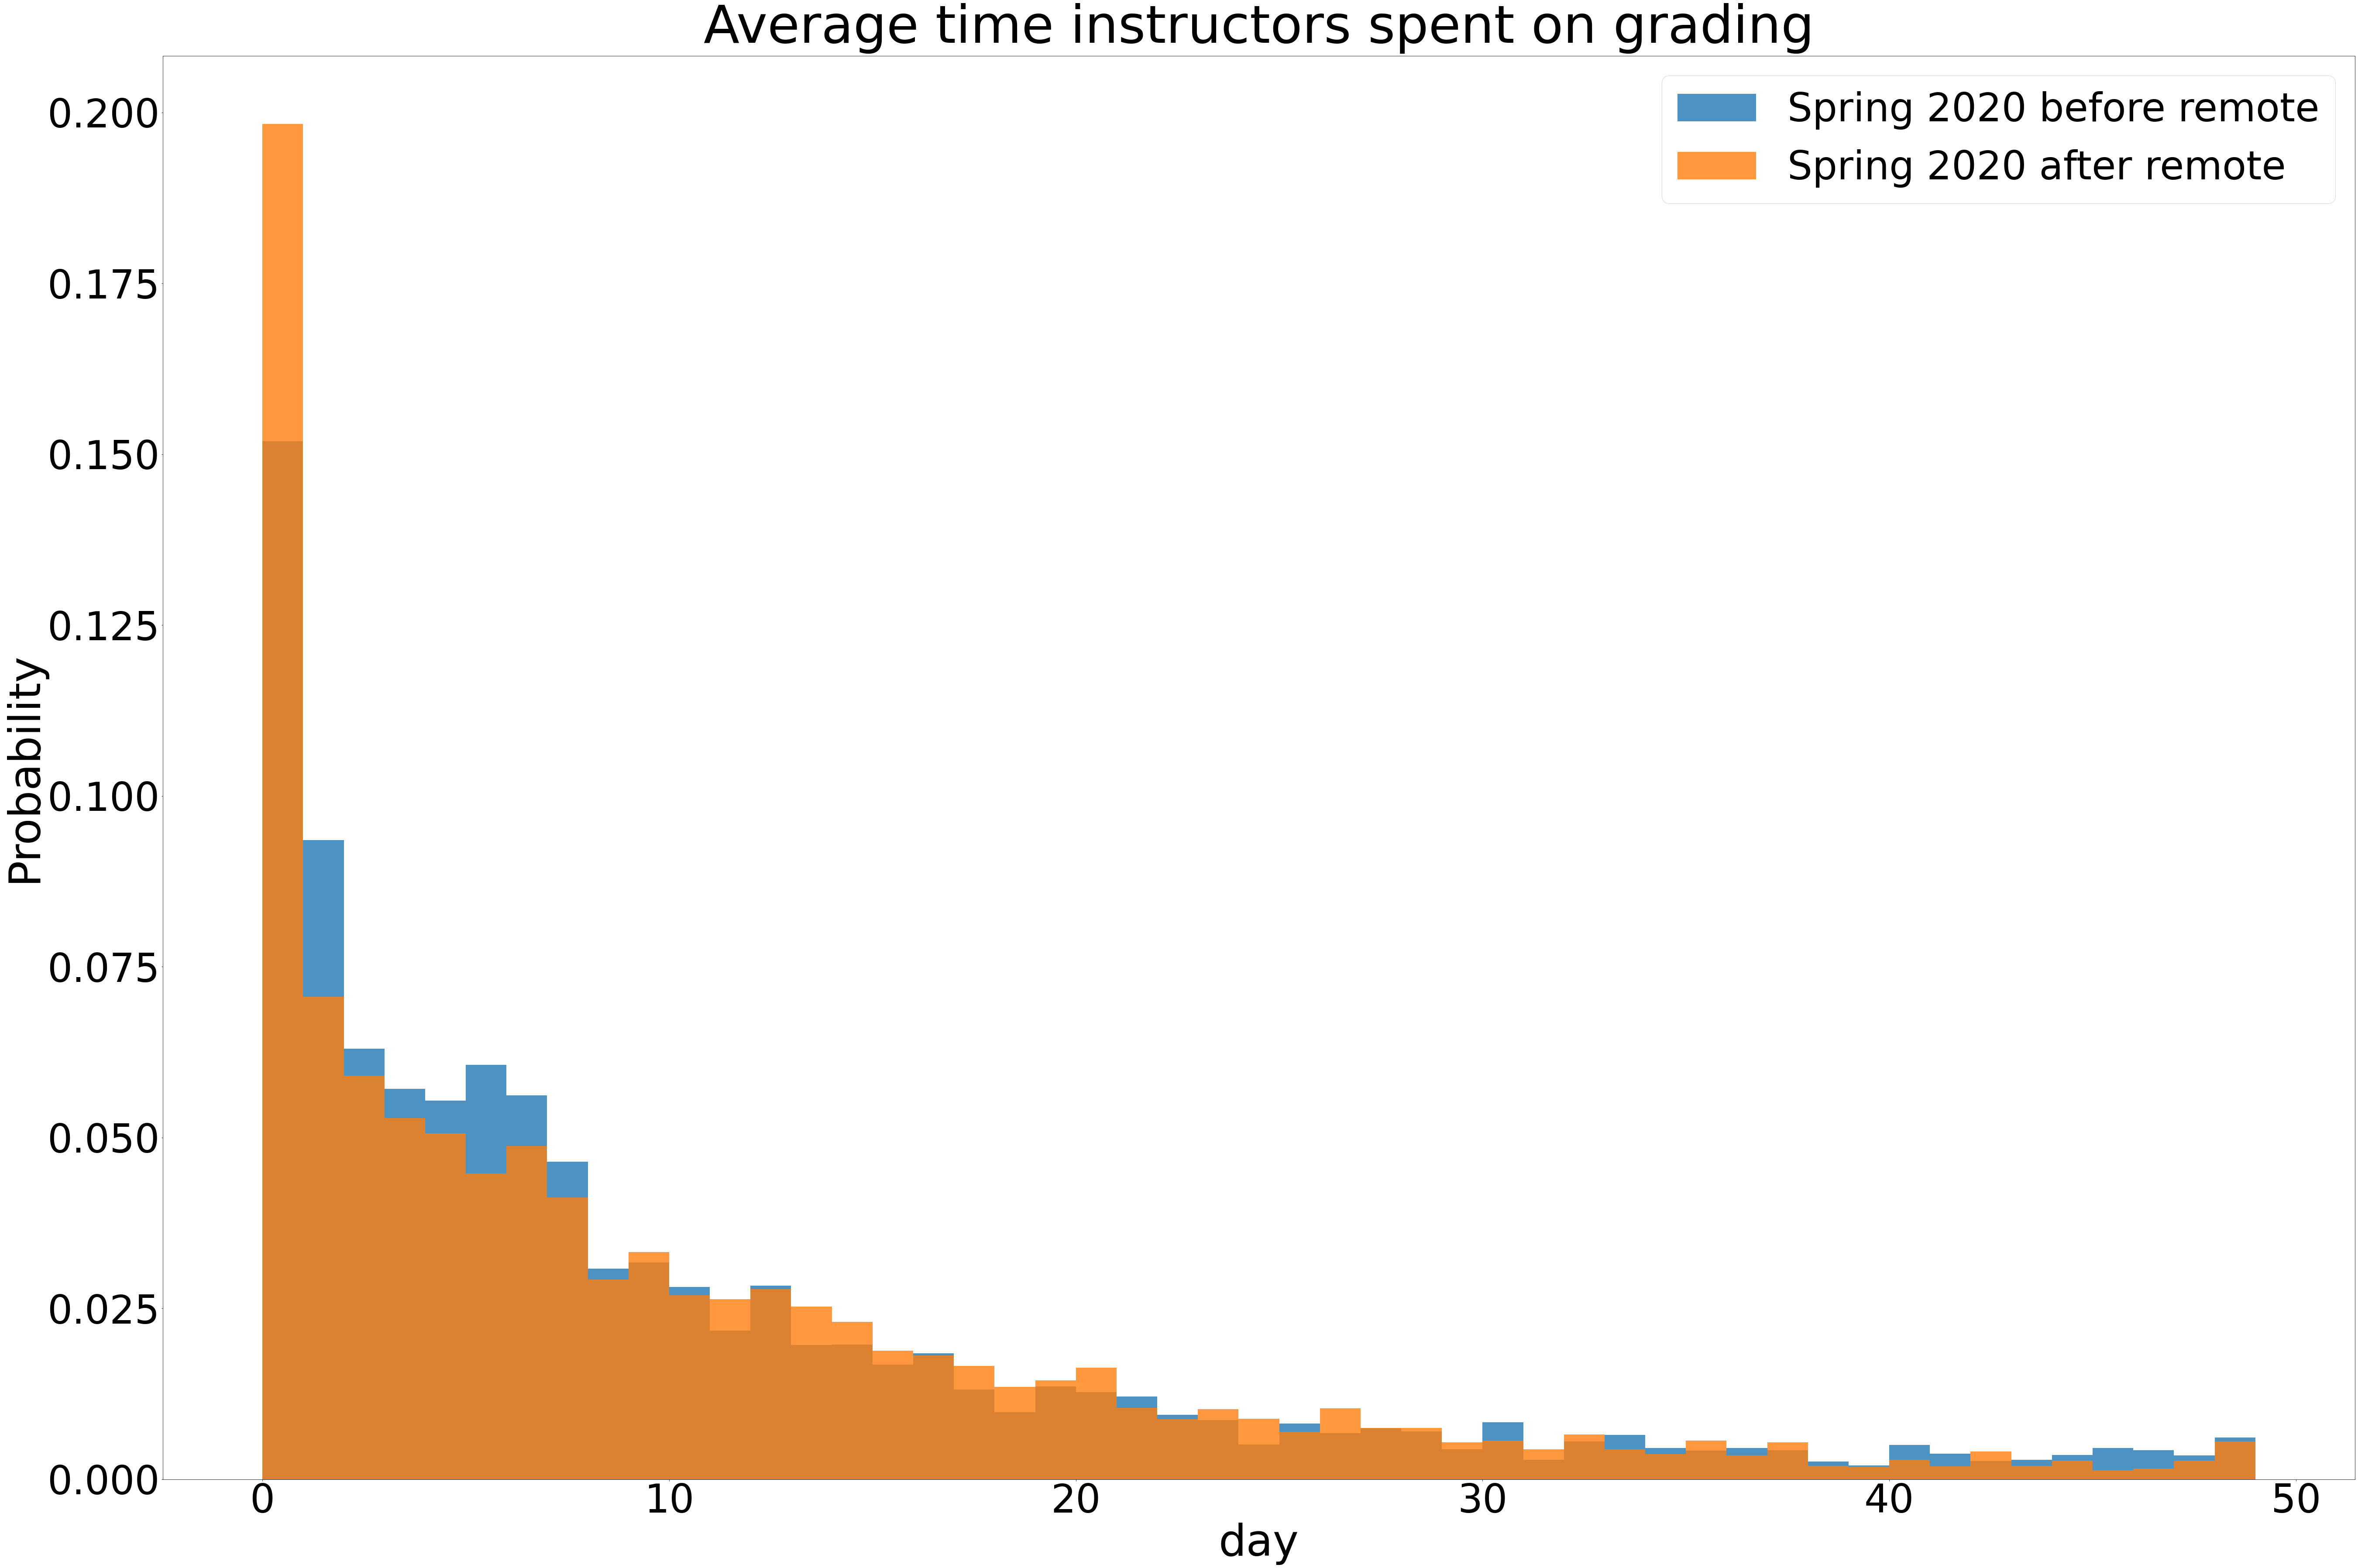

In [21]:

# 2020 Spring
assignments_submission_before = assignments_submission_before_20.loc[assignments_submission_before_20['days_grading']<60]
before = assignments_submission_before['days_grading']
print('Spring 2020 before remote instruction: mode: ', statistics.mode(before), ', median: ', statistics.median(before))
plt.hist(before, bins=range(0, 50), density=True, alpha=0.8, lw=3, ls='dashed', label='Spring 2020 before remote')
assignments_submission_after = assignments_submission_after_20.loc[assignments_submission_after_20['days_grading']<60]
after = assignments_submission_after['days_grading']
print('Spring 2020 after remote instruction: mode: ',  statistics.mode(after), ', median: ', statistics.median(after))
plt.hist(after, bins=range(0, 50), density=True, alpha=0.8, lw=3, ls='dashed', label='Spring 2020 after remote')
plt.xlabel('day')
plt.ylabel('Probability')
#plt.xticks(fontsize=100)
#plt.yticks(fontsize=100)
'''
# 2019 Spring
assignments_submission_override_19 = assignments_submission_override_19.loc[assignments_submission_override_19['days_grading']<60]
override_19 = assignments_submission_override_19['days_grading']
print('Spring 2019: mode: ', statistics.mode(override_19), ', median: ', statistics.median(override_19))
plt.hist(override_19, bins=range(0, 50), density=True, alpha=0.2, lw=3, ls='dashed', label='Spring 2019', color='green')

# 2018 Spring
assignments_submission_override_18 = assignments_submission_override_18.loc[assignments_submission_override_18['days_grading']<60]
override_18 = assignments_submission_override_18['days_grading']
print('Spring 2018: mode: ', statistics.mode(override_18), ', median: ', statistics.median(override_18))
plt.hist(override_18, bins=range(0, 50), density=True, alpha=0.2, lw=3, ls='dashed', label='Spring 2018', color='yellow')

# 2017 Spring
assignments_submission_override_17 = assignments_submission_override_17.loc[assignments_submission_override_17['days_grading']<60]
override_17 = assignments_submission_override_17['days_grading']
print('Spring 2017: mode: ', statistics.mode(override_17), ', median: ', statistics.median(override_17))
plt.hist(override_17, bins=range(0, 50), density=True, alpha=0.2, lw=3, ls='dashed', label='Spring 2017', color='orange')
'''

plt.xticks(fontsize=90)
plt.yticks(fontsize=90)
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 90
fig_size[1] = 60
plt.rcParams["figure.figsize"] = fig_size
plt.title('Average time instructors spent on grading', fontsize=120, pad=30)
plt.xlabel('day', fontsize=100)
plt.ylabel('Probability', fontsize=100)
plt.legend(prop={'size': 90})
plt.show()

Spring 2020 before remote instruction: mode:  1 , median:  9
Spring 2020 after remote instruction: mode:  1 , median:  9
Spring 2019: mode:  1 , median:  8
Spring 2018: mode:  1 , median:  8
Spring 2017: mode:  1 , median:  8.0


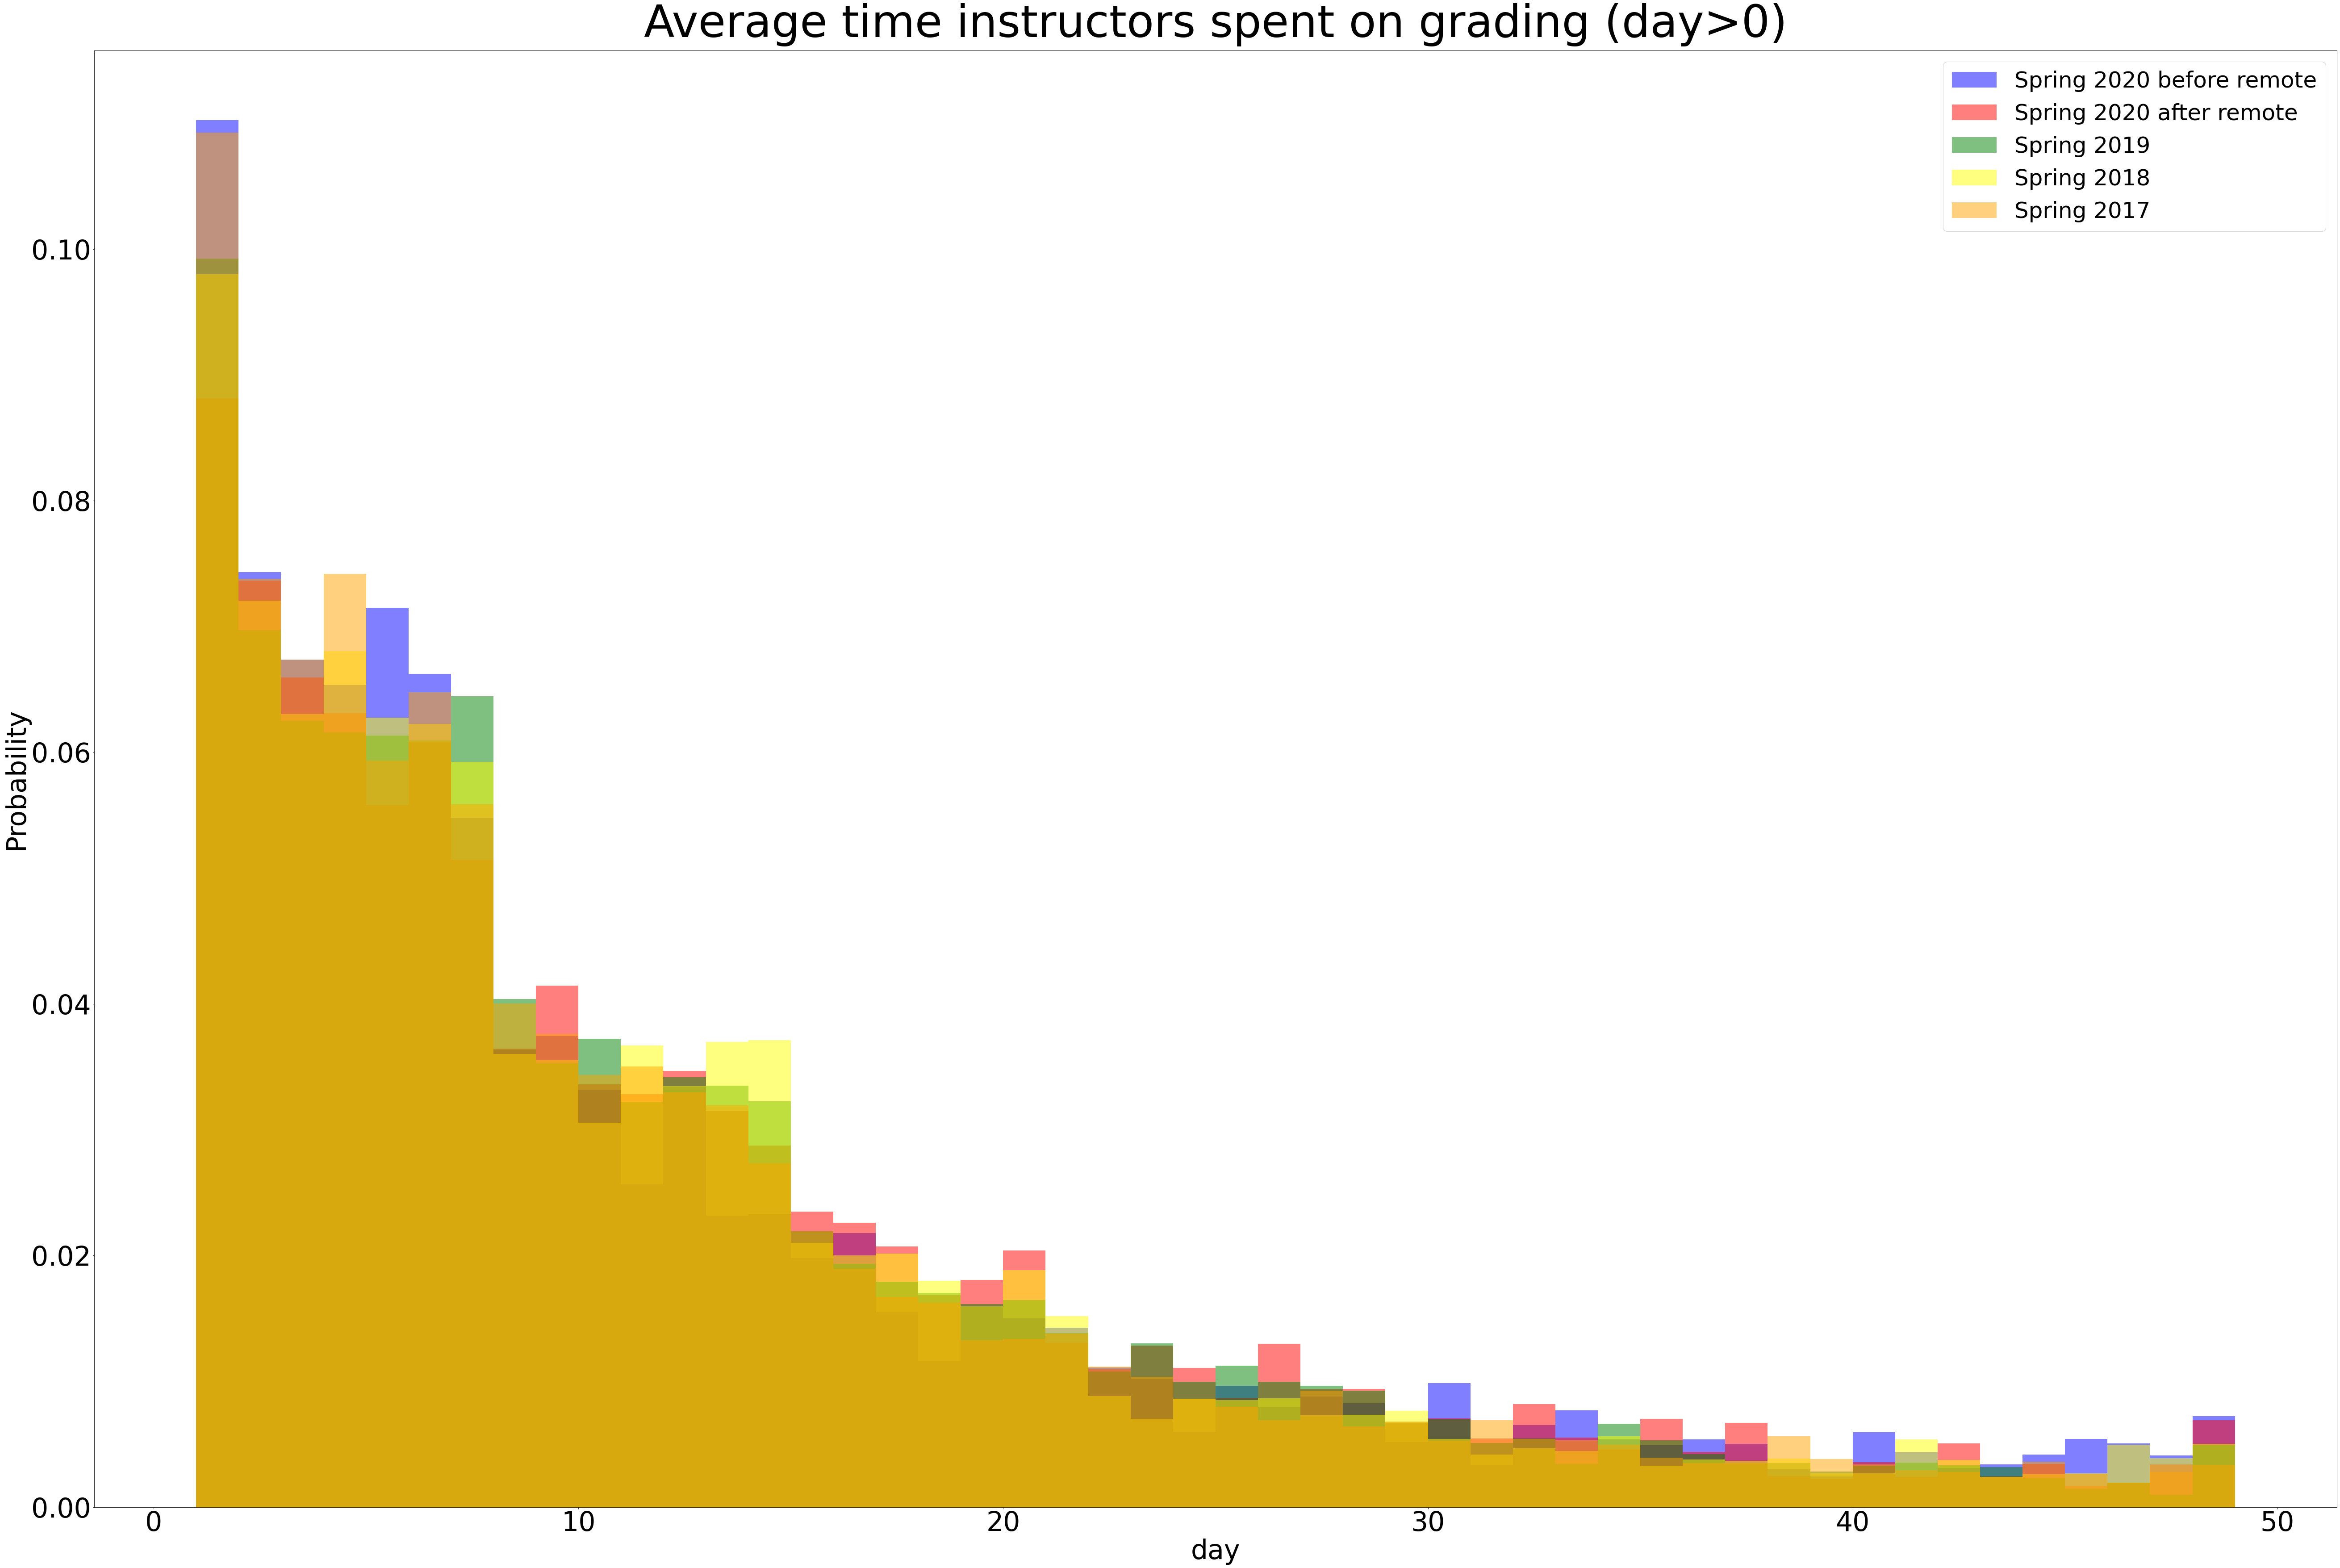

In [13]:

# 2020 Spring
before = assignments_submission_before_20.loc[assignments_submission_before_20['days_grading']>=1, ['days_grading']]['days_grading']
before = before.apply(lambda x: round(x))
print('Spring 2020 before remote instruction: mode: ', statistics.mode(before), ', median: ', statistics.median(before))
plt.hist(before, bins=range(1, 50), density=True, alpha=0.5, label='Spring 2020 before remote', color='blue')
assignments_submission_after = assignments_submission_after_20.loc[(assignments_submission_after_20['days_grading']<60)&(assignments_submission_after['days_grading']>=1)]
after = assignments_submission_after['days_grading']
after = after.apply(lambda x: round(x))
print('Spring 2020 after remote instruction: mode: ',  statistics.mode(after), ', median: ', statistics.median(after))
plt.hist(after, bins=range(1, 50), density=True, alpha=0.5, label='Spring 2020 after remote', color='red')

# 2019 Spring
override_19 = assignments_submission_override_19.loc[assignments_submission_override_19['days_grading']>=1, ['days_grading']]['days_grading']
override_19 = override_19.apply(lambda x: round(x))
print('Spring 2019: mode: ', statistics.mode(override_19), ', median: ', statistics.median(override_19))
plt.hist(override_19, bins=range(1, 50), density=True, alpha=0.5, label='Spring 2019', color='green')

# 2018 Spring
override_18 = assignments_submission_override_18.loc[assignments_submission_override_18['days_grading']>=1, ['days_grading']]['days_grading']
override_18 = override_18.apply(lambda x: round(x))
print('Spring 2018: mode: ', statistics.mode(override_18), ', median: ', statistics.median(override_18))
plt.hist(override_18, bins=range(1, 50), density=True, alpha=0.5, label='Spring 2018', color='yellow')

# 2017 Spring
override_17 = assignments_submission_override_17.loc[assignments_submission_override_17['days_grading']>=1, ['days_grading']]['days_grading']
override_17 = override_17.apply(lambda x: round(x))
print('Spring 2017: mode: ', statistics.mode(override_17), ', median: ', statistics.median(override_17))
plt.hist(override_17, bins=range(1, 50), density=True, alpha=0.5, label='Spring 2017', color='orange')

plt.xticks(fontsize=60)
plt.yticks(fontsize=60)
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 90
fig_size[1] = 60
plt.rcParams["figure.figsize"] = fig_size
plt.title('Average time instructors spent on grading (day>0)',  fontsize=100, pad=30)
plt.xlabel('day', fontsize=60)
plt.ylabel('Probability', fontsize=60)
plt.legend(prop={'size': 50})
plt.show()